### Importing Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
from scipy import stats
import math
from statsmodels.api import Logit
import scipy.stats as scs
from matplotlib.pyplot import figure
import glob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from math import sin, cos, sqrt, atan2
import geopy.distance
from itertools import cycle, islice
import math

### Reading data 

In [2]:
files_listings = glob.glob('Data/*listings1.csv')      #airbnb listings data
files_reviews = glob.glob('Data/*reviews_data.csv')    #airbnb reveiws data

**Join listings files into a dataframe**

In [3]:
df_listings = pd.DataFrame()

for file in files_listings:
    df = pd.read_csv(file) #read csv
    df = df[['id', 'host_is_superhost', 'neighbourhood', 'latitude', 'longitude','property_type', 'room_type', 
            'accommodates', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy',
             'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location',
             'review_scores_value', 'reviews_per_month', 'first_review' ]]
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['est_year'] = pd.DatetimeIndex(df['first_review']).year
    df['est_year'] = df['est_year'].astype('str')
    city = file.split('/')[1].split('_')[0]
    df['city'] = city
    df_listings = df_listings.append(df)
    
df_listings.head()

,id,host_is_superhost,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,first_review,est_year,city
0,1125097,t,"Angaston, South Australia, Australia",-34.49389,139.02942,Entire cottage,Entire home/apt,2,1.0,1.0,...,4.96,4.89,4.99,4.99,4.96,4.71,1.47,2013-09-13,2013.0,beijing
1,1133195,t,"Angaston, South Australia, Australia",-34.49403,139.03202,Entire cottage,Entire home/apt,2,1.0,1.0,...,4.80,4.87,4.98,4.87,4.89,4.60,0.52,2014-09-30,2014.0,beijing
2,1133236,t,"Angaston, South Australia, Australia",-34.49356,139.03221,Private room in rental unit,Private room,2,1.0,0.0,...,4.89,4.95,4.97,4.95,4.92,4.57,0.39,2014-01-27,2014.0,beijing
3,1710462,f,"Shea-Oak Log, South Australia, Australia",-34.51049,138.81731,Entire cabin,Entire home/apt,2,1.0,1.0,...,4.86,4.76,4.97,4.95,4.62,4.85,13.19,2018-11-25,2018.0,beijing
4,1787389,f,"Tanunda, South Australia, Australia",-34.52835,138.95364,Entire rental unit,Entire home/apt,4,2.0,2.0,...,4.59,4.76,4.88,4.88,4.88,4.13,0.24,2016-01-05,2016.0,beijing


**Join reviews files into a dataframe**

In [4]:
df_reviews = pd.DataFrame()

for file in files_reviews:
    df = pd.read_csv(file) #read file
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date']>='2018-01-01']
    df.drop(columns = ['id', 'reviewer_id', 'reviewer_name'], inplace=True)
    city = file.split('/')[1].split('_')[0]
    df['city'] = city
    df_reviews = df_reviews.append(df)
    
df_reviews.head()

,listing_id,date,comments,city
28,2595,2018-01-01,Great place. Would definitely recommend! Jenni...,newyork
29,2595,2018-04-29,We really enjoyed our stay at Jennifer’s apart...,newyork
30,2595,2018-05-18,This apartment is convenient and functional. ...,newyork
31,2595,2018-05-27,The Midtown Castle is a beautiful place to sta...,newyork
32,2595,2018-06-06,Jennifer is very nice and responsive. The loca...,newyork


### Sentiment Analysis on the reviews 

In [5]:
#Using Vader sentiment analyzser to get sentiment score of reviews
sid=SentimentIntensityAnalyzer()
def sentimentscore(x):
    try:
        pos = 0.0
        neg = 0.0
        overall = 0.0
        document = str(x['comments'])
        ss = sid.polarity_scores(document)
        pos = ss['pos']
        neg = ss['neg']
        overall = ss['compound']
        return pos, neg, overall 
    except Exception as e:
        pass
    finally:
        return pos, neg, overall

df_reviews['%postitive'], df_reviews['%negative'], df_reviews['%overall'] =  df_reviews.apply(sentimentscore, axis=1, result_type='expand').T.values

In [6]:
df_reviews.head()

,listing_id,date,comments,city,%postitive,%negative,%overall
28,2595,2018-01-01,Great place. Would definitely recommend! Jenni...,newyork,0.696,0.00,0.9437
29,2595,2018-04-29,We really enjoyed our stay at Jennifer’s apart...,newyork,0.152,0.00,0.9019
30,2595,2018-05-18,This apartment is convenient and functional. ...,newyork,0.145,0.00,0.5256
31,2595,2018-05-27,The Midtown Castle is a beautiful place to sta...,newyork,0.304,0.00,0.9371
32,2595,2018-06-06,Jennifer is very nice and responsive. The loca...,newyork,0.170,0.08,0.8274


### Data Preparation 

In [7]:
df_hotels = df_listings[df_listings['room_type'] == 'Hotel room'].copy()
df_others = df_listings[~(df_listings['room_type'] == 'Hotel room')].copy()

df_hotels['nearbyhost'] = 0
df_hotels['nearbysuperhost'] = 0
df_hotels['nearbyprivateroom'] = 0

df1 = pd.DataFrame()
df2 = pd.DataFrame()
for i,r in df_hotels.iterrows():
    c1 = (r['latitude'], r['longitude'])
    df_others1 = df_others[df_others['city'] == r['city']]
    flag = 0
    flag1 = 0
    flag2 = 0
    
    for y in df_others1.itertuples():
        c2 = (y.latitude , y.longitude)
        if(geopy.distance.distance(c1, c2).km<=0.1):
            flag = 1
            break
    if flag == 1:
        df_hotels.loc[i,'nearbyhost'] = 1
        
    for y in df_others1.itertuples():
        c2 = (y.latitude , y.longitude)
        if(geopy.distance.distance(c1, c2).km<=0.1):
            if(y.host_is_superhost == 't'):
                flag1 = 1
                break
    if flag1 == 1:
        df_hotels.loc[i,'nearbysuperhost'] = 1
     
    df_others2 = df_others1[df_others1['room_type'] == 'Private room']
    for y in df_others2.itertuples():
        c2 = (y.latitude , y.longitude)
        if(geopy.distance.distance(c1, c2).km<=0.1):
            if(y.host_is_superhost == 't'):
                flag2 = 1
                break
    if flag2 == 1:
        df_hotels.loc[i,'nearbyprivateroom'] = 1
        
df_hotels.head()

,id,host_is_superhost,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,...,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,first_review,est_year,city,nearbyhost,nearbysuperhost,nearbyprivateroom
45,14031240,t,NaN,-34.53891,138.97053,Room in bed and breakfast,Hotel room,2,1.0,1.0,...,5.00,5.00,4.93,0.24,2016-10-07,2016.0,beijing,0,0,0
0,50904,f,NaN,51.21825,4.39901,Room in boutique hotel,Hotel room,2,1.0,1.0,...,5.00,5.00,5.00,0.03,2015-05-06,2015.0,antwerp,1,1,0
17,891884,f,"Antwerp, Flemish Region, Belgium",51.21825,4.39901,Room in boutique hotel,Hotel room,2,1.0,1.0,...,5.00,5.00,4.50,0.08,2019-10-20,2019.0,antwerp,1,1,0
720,33005678,f,NaN,51.21039,4.42708,Room in aparthotel,Hotel room,2,1.0,2.0,...,4.76,4.18,4.35,0.56,2019-05-05,2019.0,antwerp,1,1,0
721,33005778,f,NaN,51.21039,4.42708,Room in aparthotel,Hotel room,2,1.0,2.0,...,4.30,4.00,3.96,0.75,2019-04-22,2019.0,antwerp,1,1,0


In [8]:
len(df_hotels[df_hotels['nearbyhost'] == 0]), len(df_hotels[df_hotels['nearbyhost'] == 1])

(107, 1554)

In [9]:
len(df_hotels[df_hotels['nearbysuperhost'] == 0]), len(df_hotels[df_hotels['nearbysuperhost'] == 1])

(503, 1158)

In [10]:
len(df_hotels[df_hotels['nearbyprivateroom'] == 0]), len(df_hotels[df_hotels['nearbyprivateroom'] == 1])

(992, 669)

In [11]:
df_hotels['est_year'] = df_hotels['est_year'].astype(float)
df_temp = df_reviews.groupby(['listing_id']).agg({'%overall':'mean','date':'count'}).reset_index()
df_temp.rename(columns = {'date':'#listings', 'listing_id':'id'}, inplace=True)
df_temp.head()

,id,%overall,#listings
0,2265,0.892600,6
1,2595,0.678415,20
2,2818,0.784548,64
3,3831,0.680349,242
4,5121,0.966800,1


In [12]:
df_final = df_hotels.merge(df_temp,on ='id',how='left')
df_final['nearbyhost'] = df_final['nearbyhost'].astype(str)
df_final['nearbysuperhost'] = df_final['nearbysuperhost'].astype(str)
df_final['nearbyprivateroom'] = df_final['nearbyprivateroom'].astype(str)
df_final.head()

,id,host_is_superhost,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,...,review_scores_value,reviews_per_month,first_review,est_year,city,nearbyhost,nearbysuperhost,nearbyprivateroom,%overall,#listings
0,14031240,t,NaN,-34.53891,138.97053,Room in bed and breakfast,Hotel room,2,1.0,1.0,...,4.93,0.24,2016-10-07,2016.0,beijing,0,0,0,0.880908,13.0
1,50904,f,NaN,51.21825,4.39901,Room in boutique hotel,Hotel room,2,1.0,1.0,...,5.00,0.03,2015-05-06,2015.0,antwerp,1,1,0,0.857000,1.0
2,891884,f,"Antwerp, Flemish Region, Belgium",51.21825,4.39901,Room in boutique hotel,Hotel room,2,1.0,1.0,...,4.50,0.08,2019-10-20,2019.0,antwerp,1,1,0,0.788800,2.0
3,33005678,f,NaN,51.21039,4.42708,Room in aparthotel,Hotel room,2,1.0,2.0,...,4.35,0.56,2019-05-05,2019.0,antwerp,1,1,0,0.243918,17.0
4,33005778,f,NaN,51.21039,4.42708,Room in aparthotel,Hotel room,2,1.0,2.0,...,3.96,0.75,2019-04-22,2019.0,antwerp,1,1,0,0.098922,23.0


In [13]:
df_listings['roomType'] = ''
for i,r in df_listings.iterrows():
    if(r['room_type'] == 'Hotel room'):
        df_listings.loc[i,'roomType'] = 'Hotels'
    else:
        df_listings.loc[i,'roomType'] = 'Regular hosts'

### Exploratory Data Analysis 

**Number of listings by Airbnb type**

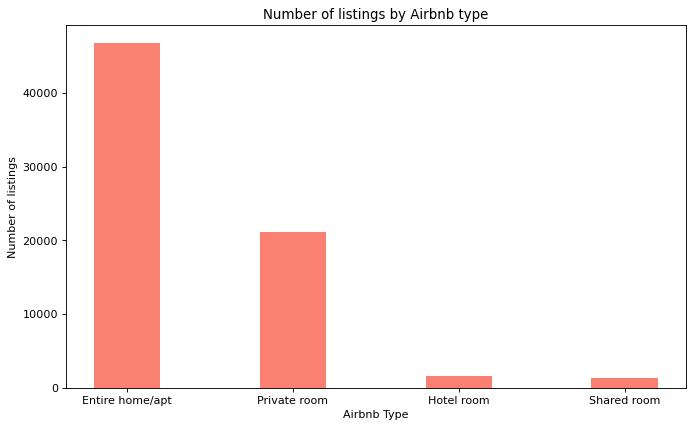

In [14]:
l = df_listings['room_type'].value_counts()
figure(figsize=(10, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Number of listings by Airbnb type")
plt.ylabel("Number of listings")
plt.xlabel("Airbnb Type")
plt.show()

**Number of New Hotel room listings as Airbnb by Year**

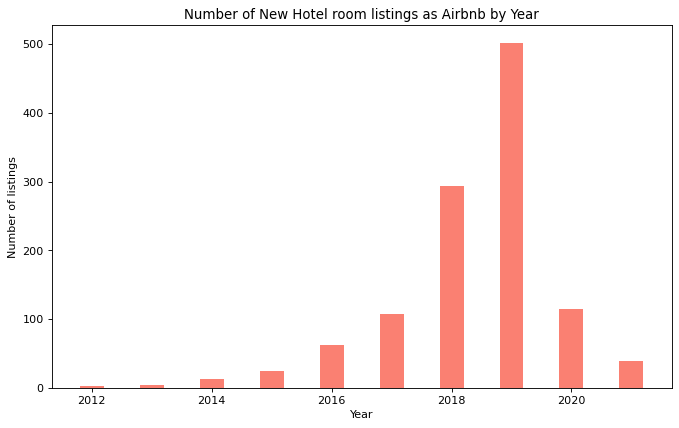

In [15]:
l = df_hotels['est_year'].value_counts()
a= []
b= []
for index, (value1, value2) in enumerate(zip(list(l.index), list(l.values))):
    if(~(math.isnan(value1))):
        a.append(str(value1))
        b.append(value2)
figure(figsize=(10, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Number of New Hotel room listings as Airbnb by Year")
plt.ylabel("Number of listings")
plt.xlabel("Year")
plt.show()

**Number of listings by Airbnb type and city**

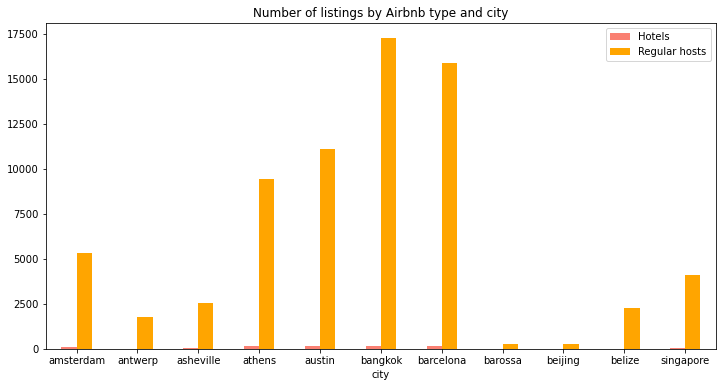

In [16]:
df1 = df_listings.groupby(['city', 'roomType'])['id'].count().unstack().fillna(0)
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Number of listings by Airbnb type and city')
plt.xticks(rotation=0, ha='center')
plt.legend(loc = 1)
plt.show()

**Average Occupancy per month by Airbnb type**

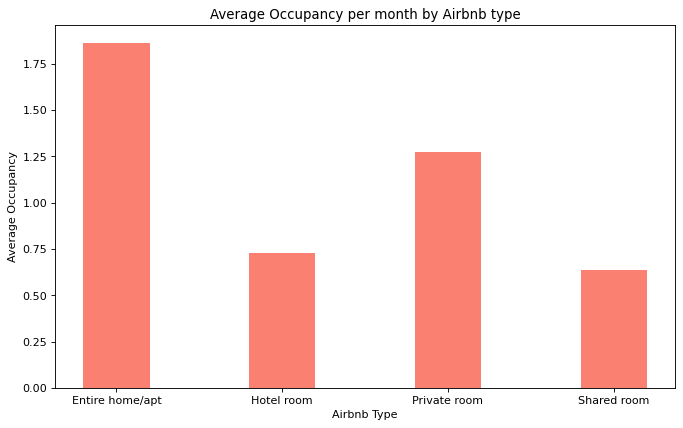

In [17]:
l = df_listings.groupby('room_type').mean()['reviews_per_month']
figure(figsize=(10, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Average Occupancy per month by Airbnb type")
plt.ylabel("Average Occupancy")
plt.xlabel("Airbnb Type")
plt.show()

**Average Occupancy per month by Airbnb type and city**

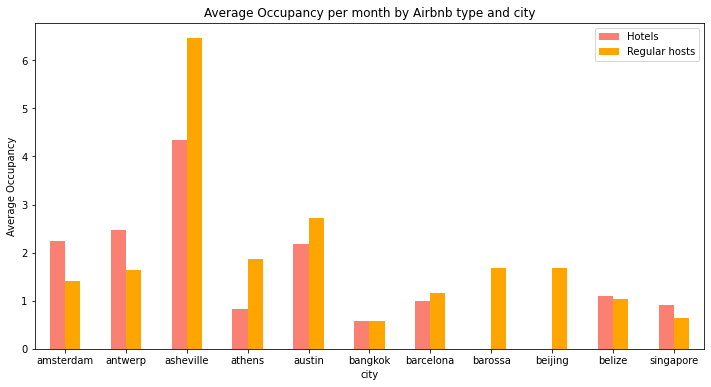

In [18]:
df1 = df_listings.groupby(['city', 'roomType'])['reviews_per_month'].mean().unstack().fillna(0)
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color=my_colors)
plt.title('Average Occupancy per month by Airbnb type and city')
plt.ylabel("Average Occupancy")
plt.xticks(rotation=0, ha='center')
plt.legend(loc = 1)
plt.show()

**Average Ratings by Airbnb type**

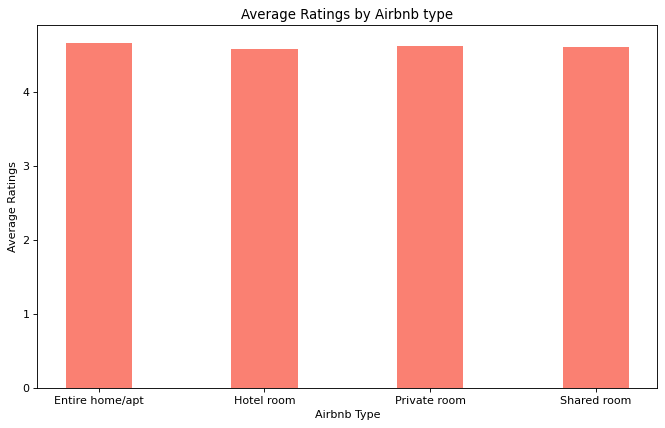

In [19]:
l = df_listings.groupby('room_type').mean()['review_scores_value']
figure(figsize=(10, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Average Ratings by Airbnb type")
plt.ylabel("Average Ratings")
plt.xlabel("Airbnb Type")
plt.show()

**Average Ratings by Airbnb type and city**

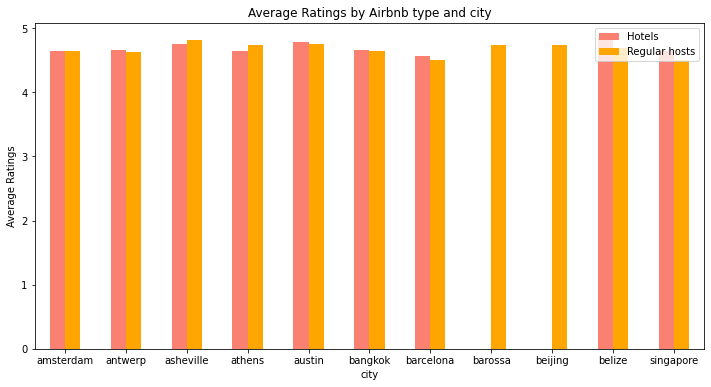

In [20]:
df1 = df_listings.groupby(['city', 'roomType'])['review_scores_value'].mean().unstack().fillna(0)
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Ratings by Airbnb type and city')
plt.ylabel("Average Ratings")
plt.xticks(rotation=0, ha='center')
plt.legend(loc = 1)
plt.show()

### Effect of nearby regular host on boutique hotel

**Number of Hotel room listings**

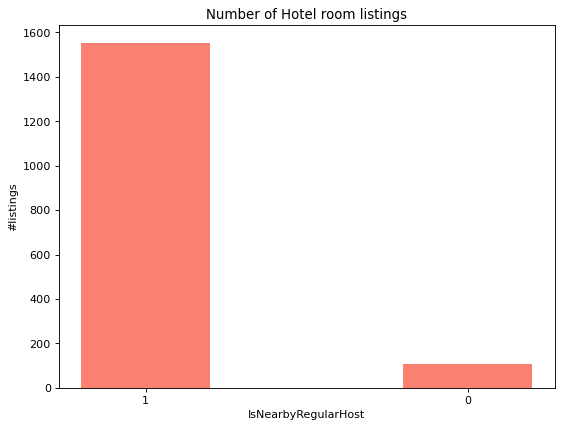

In [21]:
l = df_final['nearbyhost'].value_counts()
figure(figsize=(8, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Number of Hotel room listings")
plt.ylabel("#listings")
plt.xlabel("IsNearbyRegularHost")
plt.show()

**Average Occupancy per month for Hotel room**

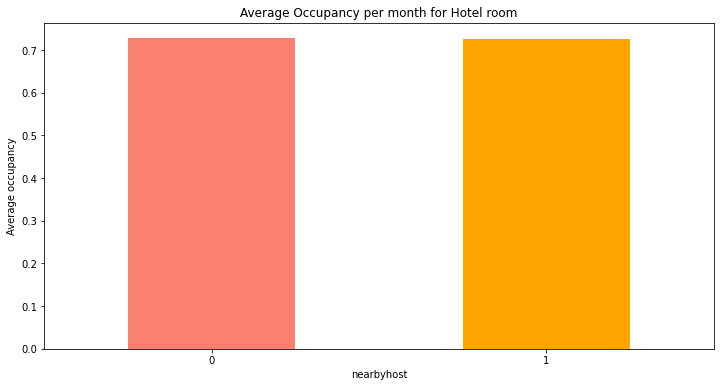

In [22]:
df1 = df_final.groupby(['nearbyhost'])['reviews_per_month'].mean()
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Occupancy per month for Hotel room')
plt.xticks(rotation=0, ha='center')
plt.ylabel("Average occupancy")
plt.show()

### Effect of nearby super host on boutique hotel

**Number of Hotel room listings**

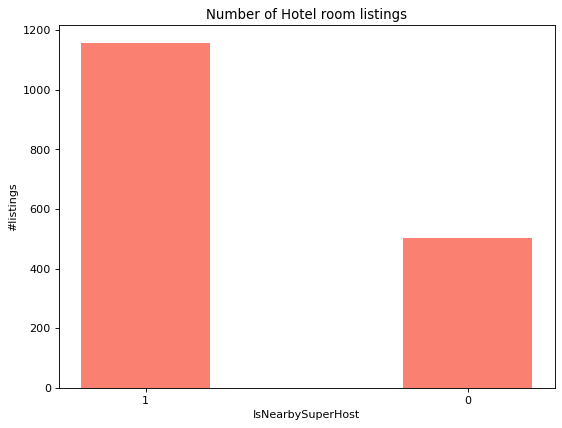

In [23]:
l = df_final['nearbysuperhost'].value_counts()
figure(figsize=(8, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Number of Hotel room listings")
plt.ylabel("#listings")
plt.xlabel("IsNearbySuperHost")
plt.show()

**Average Occupancy per month for Hotel room**

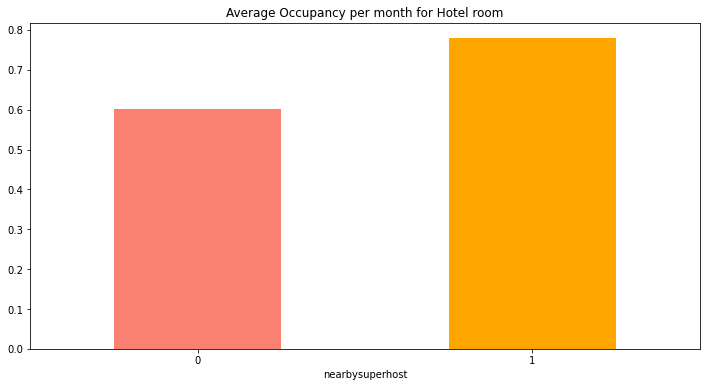

In [24]:
df1 = df_final.groupby(['nearbysuperhost'])['reviews_per_month'].mean()
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Occupancy per month for Hotel room')
plt.xticks(rotation=0, ha='center')
plt.show()

### Effect of nearbyprivate rrom type airbnb on boutique hotel

**Number of Hotel room listings**

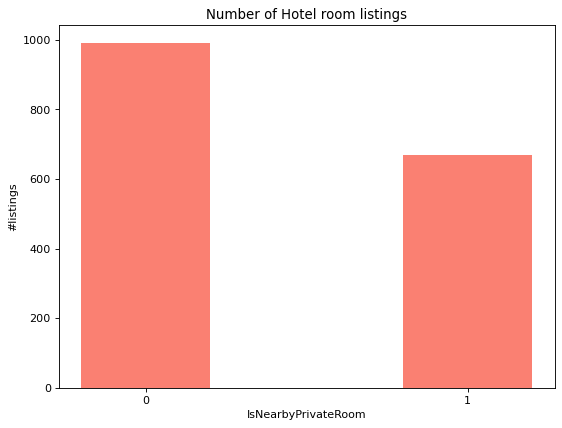

In [25]:
df_final['nearbyprivateroom'] = df_final['nearbyprivateroom'].astype(str)
l = df_final['nearbyprivateroom'].value_counts()
figure(figsize=(8, 6), dpi=80)
plt.bar(l.index, l.values, width=0.4, color='salmon', align='center', label = '#listings')
plt.title("Number of Hotel room listings")
plt.ylabel("#listings")
plt.xlabel("IsNearbyPrivateRoom")
plt.show()

**Average Occupancy per month for Hotel room**

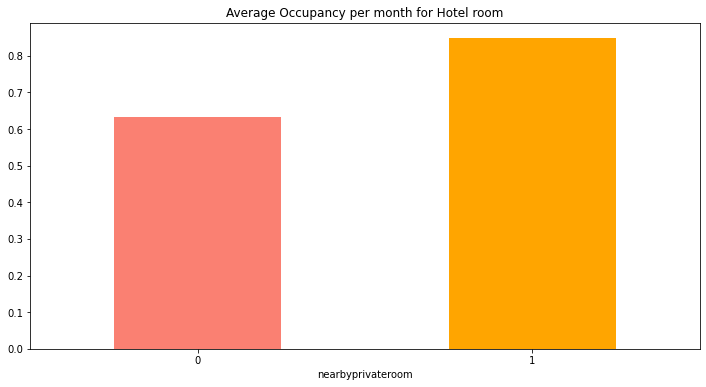

In [26]:
df1 = df_final.groupby(['nearbyprivateroom'])['reviews_per_month'].mean()
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Occupancy per month for Hotel room')
plt.xticks(rotation=0, ha='center')
plt.show()

**Average Occupancy per month for Hotel room by city (nearbyprivateroom)**

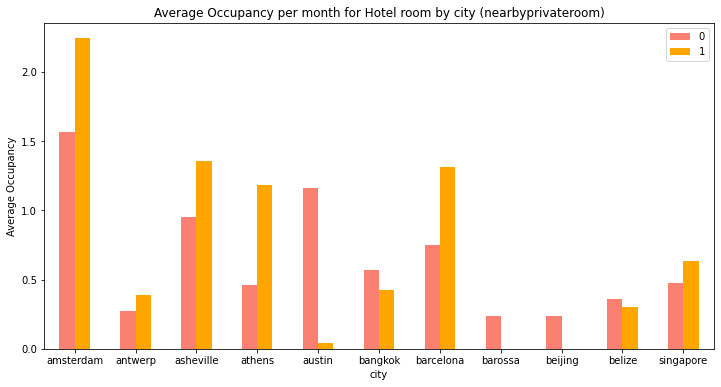

In [27]:
df1 = df_final.groupby(['city','nearbyprivateroom'])['reviews_per_month'].mean().unstack().fillna(0)
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Occupancy per month for Hotel room by city (nearbyprivateroom)')
plt.ylabel("Average Occupancy")
plt.xticks(rotation=0, ha='center')
plt.legend(loc = 1)
plt.show()

**Average Occupancy per month for Hotel room by city (nearbysuperhost)**

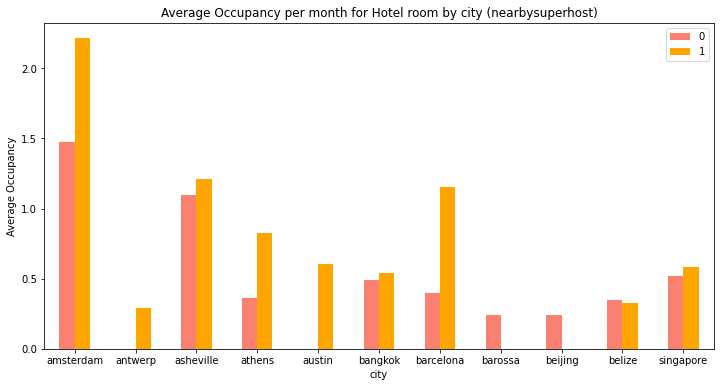

In [28]:
df1 = df_final.groupby(['city','nearbysuperhost'])['reviews_per_month'].mean().unstack().fillna(0)
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Occupancy per month for Hotel room by city (nearbysuperhost)')
plt.ylabel("Average Occupancy")
plt.xticks(rotation=0, ha='center')
plt.legend(loc = 1)
plt.show()

**Average Occupancy per month for Hotel room by city (nearbyhost)**

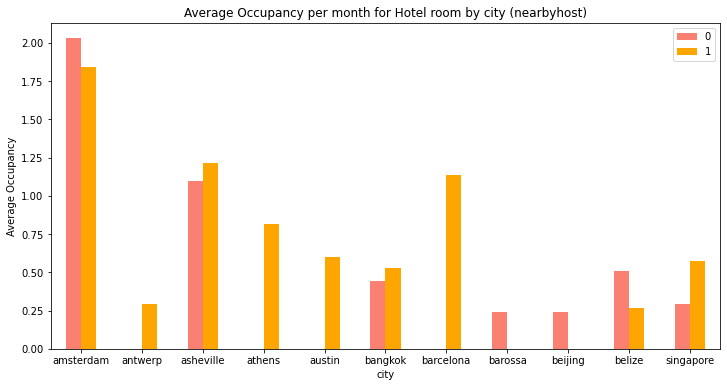

In [29]:
df1 = df_final.groupby(['city','nearbyhost'])['reviews_per_month'].mean().unstack().fillna(0)
my_colors = list(islice(cycle(['salmon', 'orange']), None, len(df1)))
df1.plot(kind='bar', figsize=(12, 6), color = my_colors)
plt.title('Average Occupancy per month for Hotel room by city (nearbyhost)')
plt.ylabel("Average Occupancy")
plt.xticks(rotation=0, ha='center')
plt.legend(loc = 1)
plt.show()

### Hypothesis Testing

In [30]:
df_final.to_csv('df_final.csv', index = False)
df_listings.to_csv('df_listings.csv', index = False)

In [31]:
#returns pvalue 
def ttest(l1,l2):
    return stats.ttest_ind(l1,l2)[1]

**Effect of nearby super host on reviews per month of a boutique hotel**

In [32]:
ttest(df_final[df_final['nearbysuperhost']=='0']['reviews_per_month'].dropna(),df_final[df_final['nearbysuperhost']=='1']['reviews_per_month'].dropna())

0.06941441817179118

**Effect of nearby private room on reviews per month of a boutique hotel**

In [33]:
ttest(df_final[df_final['nearbyprivateroom']=='0']['reviews_per_month'].dropna(),df_final[df_final['nearbyprivateroom']=='1']['reviews_per_month'].dropna())

0.017170143266385524

In [43]:
df_final1 = df_final[['beds','price','reviews_per_month','review_scores_value','nearbyhost', 'nearbysuperhost', 'nearbyprivateroom', '%overall', '#listings']].copy()

### Regression Modelling 

In [44]:
df_final1['price'] = df_final1['price'].replace({'\$':''}, regex = True)
df_final1['price'] = df_final1['price'].replace({',':''}, regex = True)
df_final1['price'] = df_final1['price'].astype(float)
df_final1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1661 entries, 0 to 1660
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   beds                 1631 non-null   float64
 1   price                1661 non-null   float64
 2   reviews_per_month    1163 non-null   float64
 3   review_scores_value  1157 non-null   float64
 4   nearbyhost           1661 non-null   object 
 5   nearbysuperhost      1661 non-null   object 
 6   nearbyprivateroom    1661 non-null   object 
 7   %overall             1093 non-null   float64
 8   #listings            1093 non-null   float64
dtypes: float64(6), object(3)
memory usage: 129.8+ KB


In [45]:
df_final2 = pd.get_dummies(df_final1,drop_first=True)
df_final2.dropna(inplace=True)

In [46]:
#log transformation on skwewed features
col = ['beds','price','reviews_per_month','review_scores_value', '%overall', '#listings']
for c in col:
    df_final2[c] = np.log(df_final2[c]+1)

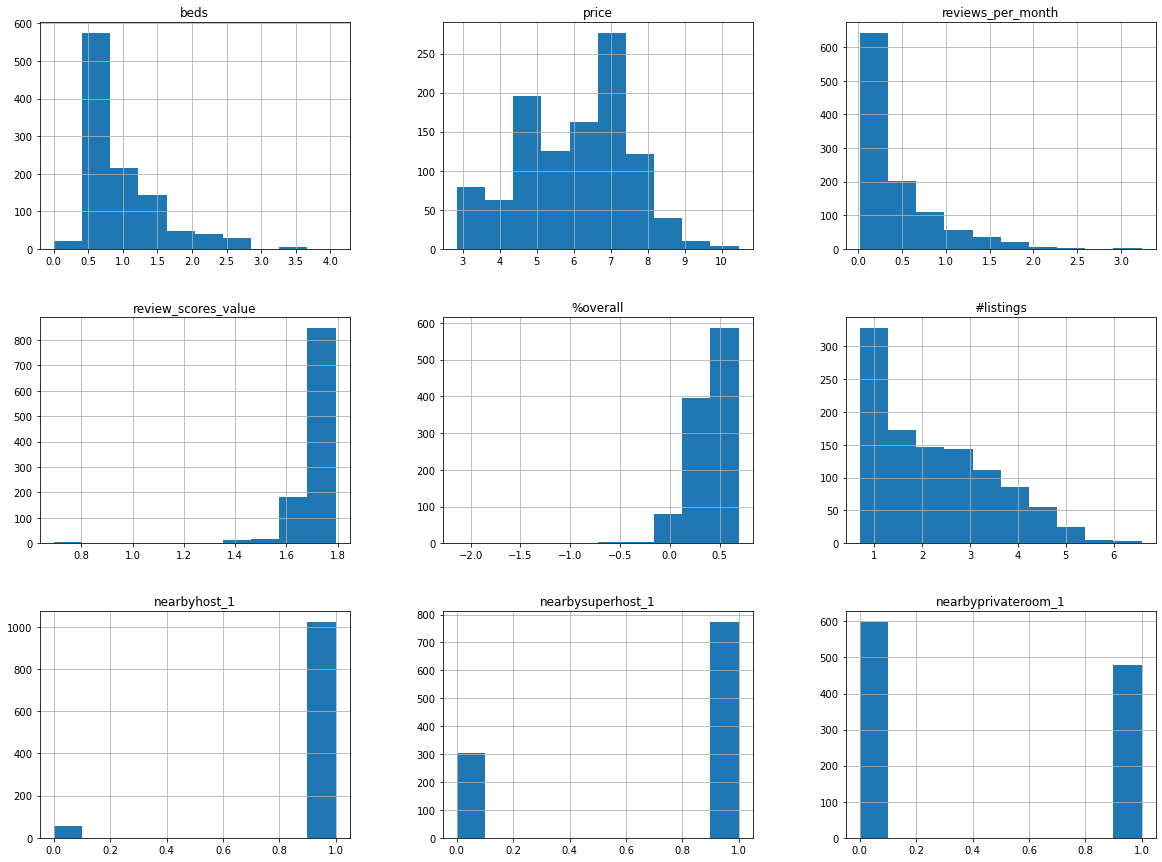

In [47]:
#checking distribution after trasnformations
df_final2.hist(figsize=(20, 15))
plt.show()

In [48]:
df_final2.rename(columns = {'reviews_per_month':'average_bookings_per_month'},inplace = True)

**OLS Model**

In [49]:
X = df_final2.drop(columns = ['average_bookings_per_month', '#listings','%overall'])
y = df_final2[['average_bookings_per_month']]

OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     average_bookings_per_month   R-squared (uncentered):                   0.473
Model:                                    OLS   Adj. R-squared (uncentered):              0.470
Method:                         Least Squares   F-statistic:                              159.9
Date:                        Sun, 06 Mar 2022   Prob (F-statistic):                   6.64e-145
Time:                                01:25:00   Log-Likelihood:                         -659.99
No. Observations:                        1076   AIC:                                      1332.
Df Residuals:                            1070   BIC:                                      1362.
Df Model:                                   6                                                  
Covariance Type:                    nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
beds                   -0.0932      0.025     -3.805      0.000      -0.141      -0.045
price                  -0.0688      0.010     -7.204      0.000      -0.088      -0.050
review_scores_value     0.4976      0.049     10.138      0.000       0.401       0.594
nearbyhost_1            0.0541      0.065      0.832      0.406      -0.074       0.182
nearbysuperhost_1       0.0194      0.039      0.504      0.615      -0.056       0.095
nearbyprivateroom_1     0.0059      0.034      0.173      0.863      -0.061       0.073
==============================================================================
Omnibus:                      381.436   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1228.752
Skew:                           1.762   Prob(JB):                    1.51e-267
Kurtosis:                       6.872   Cond. No.                         35.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""